<a href="https://colab.research.google.com/github/VisionLogic-AI/Object_Detection_Projects/blob/branch_1/Age_Prediction_Using_Brain_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#use tensorflow 1.x backend
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 1.x selected.
1.15.2


In [0]:
#ensure that we are using tensorflow 1.x and not 2.x
%tensorflow_version 1.x

#Next, we import the necessary modules or libraries 

In [3]:
#clone into the dataset hostged on Gtuhub (or upload from downloads)
!wget -nc https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/requirements.txt

--2020-05-16 22:32:08--  https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1317 (1.3K) [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]   1.29K  --.-KB/s    in 0s      

2020-05-16 22:32:09 (82.7 MB/s) - ‘requirements.txt’ saved [1317/1317]



In [4]:
#install requirements.txt files 
!pip install -r requirements.txt

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 153kB 39.0MB/s 
     |████████████████████████████████| 2.2MB 49.5MB/s 
     |████████████████████████████████| 2.8MB 55.6MB/s 
     |████████████████████████████████| 890kB 56.9MB/s 
     |████████████████████████████████| 122kB 58.6MB/s 
     |████████████████████████████████| 778kB 53.5MB/s 
     |████████████████████████████████| 112kB 55.5MB/s 
     |████████████████████████████████| 184kB 59.7MB/s 
     |████████████████████████████████| 133kB 59.6MB/s 
     |████████████████████████████████| 286kB 58.4MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 
     |████████████████████████████████| 92kB 15.2MB/s 
     |████████████████████████████████| 133kB 64.7MB/s 
     |████████████████████████████████| 14.8MB 201kB/s 
     |████████████████████████████████| 317kB 53.5MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 92kB 813kB/s

#Step 0: Load & Setup the Data  

In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import random as ran
import matplotlib

#Deep learning package
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv3D, MaxPooling3D, AveragePooling3D, Input, ZeroPadding3D
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, Adadelta, RMSprop, Adamax, Nadam, SGD  #using Adam in this model..just showing others
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
#neuroimaging specific python packages
import nilearn
from nilearn import plotting
import nibabel as nib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
!wget -nc https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/data/pheno_file.csv

--2020-05-16 22:36:57--  https://raw.githubusercontent.com/saigerutherford/anatomically_defined_CNNs/master/data/pheno_file.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51946 (51K) [text/plain]
Saving to: ‘pheno_file.csv’

pheno_file.csv      100%[===================>]  50.73K  --.-KB/s    in 0.002s  

2020-05-16 22:36:57 (29.2 MB/s) - ‘pheno_file.csv’ saved [51946/51946]



In [4]:
#Read in the csv file with subject info
pheno= pd.read_csv('/content/pheno_file.csv')
print(pheno.head(10))
pheno['Age'].describe()

            Subject           EID  Sex  ...  EHQ_Total  Commercial_Use Full_Pheno
0  sub-NDARAA075AMK  NDARAA075AMK    1  ...      65.57              No        Yes
1  sub-NDARAA536PTU  NDARAA536PTU    0  ...     -86.71              No        Yes
2  sub-NDARAA948VFH  NDARAA948VFH    1  ...      90.05             Yes         No
3  sub-NDARAC349YUC  NDARAC349YUC    1  ...      86.71             Yes        Yes
4  sub-NDARAC350BZ0  NDARAC350BZ0    0  ...      66.77             Yes         No
5  sub-NDARAC350XUM  NDARAC350XUM    0  ...      46.69             Yes         No
6  sub-NDARAC853DTE  NDARAC853DTE    0  ...      83.38             Yes        Yes
7  sub-NDARAC857HDB  NDARAC857HDB    0  ...      53.36             Yes         No
8  sub-NDARAC904DMU  NDARAC904DMU    1  ...      71.17             Yes        Yes
9  sub-NDARAD224CRB  NDARAD224CRB    0  ...      56.70             Yes         No

[10 rows x 7 columns]


count    906.000000
mean      10.824074
std        3.558937
min        5.036048
25%        8.039898
50%       10.031599
75%       13.057266
max       21.816563
Name: Age, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

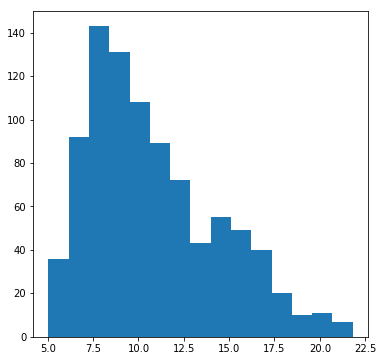

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.hist(pheno['Age'], bins=15)
plt.show

In [7]:
!wget -nc https://storage.googleapis.com/ohbm-dl-lindsay-data/OHBM_DL_SR_data.zip

--2020-05-16 22:38:56--  https://storage.googleapis.com/ohbm-dl-lindsay-data/OHBM_DL_SR_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265718959 (253M) [application/zip]
Saving to: ‘OHBM_DL_SR_data.zip’

OHBM_DL_SR_data.zip 100%[===================>] 253.41M  29.4MB/s    in 8.6s    

2020-05-16 22:39:05 (29.4 MB/s) - ‘OHBM_DL_SR_data.zip’ saved [265718959/265718959]



In [8]:
!unzip -uo OHBM_DL_SR_data.zip

Archive:  OHBM_DL_SR_data.zip
  inflating: OHBM_DL_data/downsampled_test_labels.npy  
  inflating: OHBM_DL_data/savedmodels/metadata_batch20_epoch10.tsv  
  inflating: OHBM_DL_data/downsampled_train_labels.npy  
  inflating: OHBM_DL_data/savedmodels/best_weights_batch5epoch30.h5  
  inflating: OHBM_DL_data/savedmodels/log_batch20epoch10.csv  
  inflating: OHBM_DL_data/savedmodels/weights.20-12.44.hdf5  
  inflating: OHBM_DL_data/savedmodels/best_weights_batch20epoch10.h5  
  inflating: OHBM_DL_data/savedmodels/metadata_batch5_epoch30.tsv  
  inflating: OHBM_DL_data/savedmodels/metadata_batch10_epoch20.tsv  
  inflating: OHBM_DL_data/savedmodels/log_batch10epoch20.csv  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch20_epoch10.h5  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch10_epoch20.h5  
  inflating: OHBM_DL_data/savedmodels/SavedModel_batch5_epoch30.h5  
  inflating: OHBM_DL_data/savedmodels/TensorBoardLogs/events.out.tfevents.1559899998.freewill  
  inflating: OHBM

In [0]:
#create root path for Colab
root_path= '/content/OHBM_DL_data/'

In [14]:
ls OHBM_DL_data

downsampled_test_labels.npy  downsampled_train_labels.npy  savedmodels/
downsampled_test.npy         downsampled_train.npy


#Load Data(already divided int train and test sets)

In [0]:
x_train= np.load(root_path + 'downsampled_train.npy')
x_test= np.load(root_path + 'downsampled_test.npy')
y_train= np.load(root_path + 'downsampled_train_labels.npy')
y_test= np.load(root_path + 'downsampled_test_labels.npy')

#Check Input Shape

In [19]:
x_train.shape

(724, 48, 60, 46, 3)

In [22]:
n_train= x_train.shape[0]
n_test= x_test.shape[0]
image_shape= x_train[0].shape
print('Number of training examples =', n_train)
print('Number of test examples =', n_test)
print('Image data shape =', image_shape)

Number of training examples = 724
Number of test examples = 182
Image data shape = (48, 60, 46, 3)


#Step1: Model Construction

In [27]:
#create o-ur CNN model
from keras.layers import Flatten   #forgot to import in earlier cells

model= Sequential()
model.add(Conv3D(filters= 64, kernel_size=(3,3,3), activation= 'elu', strides= 1, padding= 'same',
                 kernel_initializer= 'glorot_uniform',
                 input_shape= image_shape))
model.add(Conv3D(filters= 64, kernel_size=(3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(Conv3D(filters= 64, kernel_size= (3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(MaxPooling3D((2,2,2), strides= (2,2,2)))  #ppoling is also referred to as downasampling layer
model.add(BatchNormalization())  #normalize the activations of the previous layer at each batch

model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='elu', strides= (1,1,1), padding='same'))
model.add(Conv3D(filters= 32, kernel_size=(3,3,3), activation= 'elu', strides= (1,1,1), padding= 'same'))
model.add(MaxPooling3D((2,2,2), strides= (2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters= 16, kernel_size=(3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(Conv3D(filters= 16, kernel_size=(3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(MaxPooling3D((2,2,2), strides=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters= 8, kernel_size= (3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(Conv3D(filters= 8, kernel_size= (3,3,3), activation='elu', strides= (1,1,1), padding= 'same'))
model.add(MaxPooling3D((2,2,2), strides= (2,2,2)))
model.add(BatchNormalization())

model.add(AveragePooling3D((2,2,2), strides= (2,2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', name= 'features'))  #convert the output of convolutional part into 1D vector
model.add(Dense(1))  #final output is a single number (Age in this model) 
model.summary()

filename= 'best_weights.h5'
filename2= 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 48, 60, 46, 64)    5248      
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 24, 30, 23, 64)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 30, 23, 64)    256       
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 24, 30, 23, 32)    55328     
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 24, 30, 23, 32)    27680     
__________

In [0]:
checkpoints= []

if not os.path.exists('Results01/'):
  os.makedirs('Results01/')

checkpoints.append(ModelCheckpoint('Results01' + filename,
                                   monitor= 'val_loss',
                                   verbose= 1,
                                   save_best_only= True,
                                   save_weights_only= True,
                                   mode= 'auto',
                                   period= 1))

checkpoints.append(ModelCheckpoint('Results01/' + filename2,
                                   monitor= 'val_loss',
                                   verbose= 1,
                                   save_best_only= False,
                                   save_weights_only= True,
                                   mode= 'auto',
                                   period= 20))

checkpoints.append(TensorBoard(log_dir= 'Results01/TensorboardLogs',
                               histogram_freq= 0,
                               write_graph= True,
                               write_images= False,
                               embeddings_freq= 0,
                               embeddings_layer_names= ['features'],
                               embeddings_metadata= 'metadata.tsv'))

#early stopping here is set that if the MSE in the validation set does not improve after 10 epochs, training stops
checkpoints.append(EarlyStopping(monitor= 'val_loss', mode= 'auto', min_delta=0, patience= 10))
checkpoints.append(ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience= 10, verbose=0, mode='auto', mi_delta= 0.0001,
                                     cooldown= 0, min_lr= 0))
checkpoints.append(CSVLogger('Results01/log.csv'))

In [31]:
#compile our model
model.compile(loss= 'mse',  #the objective that the model will try to miniimize, Mean Squared Error in this model 
              optimizer= 'adam',
              metrics= ['mae'])  #add in any other metrics you want to use to show performance of the model such as accuracy if this was a classification problem

W0516 23:32:26.807458 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Step2: Model Training

In [32]:
#check available GPU's
K.tensorflow_backend._get_available_gpus()

W0516 23:34:00.030622 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0516 23:34:00.033770 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0516 23:34:00.038132 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0516 23:34:01.580378 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0516 23:34:01.581392 139993318365056 module_wrapper.py:13

['/job:localhost/replica:0/task:0/device:GPU:0']

In [34]:
NUM_EPOCHS= 10   #this defines for how many times the training will repeat in cycles
BATCH_SIZE= 20    #the number of training exmaples in one forwaard/backward pass (or for 1 epoch)
history1= model.fit(x_train, y_train,
                    validation_split= 0.1,
                    batch_size= BATCH_SIZE,
                    epochs= NUM_EPOCHS,
                    callbacks= checkpoints)


W0516 23:35:53.188963 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0516 23:35:53.427055 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 651 samples, validate on 73 samples


W0516 23:35:54.137706 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0516 23:35:54.139470 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
651/651 [==============================] - 67s 102ms/step - loss: 61.1841 - mean_absolute_error: 6.5634 - val_loss: 66.7337 - val_mean_absolute_error: 7.3057

Epoch 00001: val_loss improved from inf to 66.73371, saving model to Results01best_weights.h5


W0516 23:37:01.933632 139993318365056 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/10
651/651 [==============================] - 56s 85ms/step - loss: 13.1471 - mean_absolute_error: 2.9944 - val_loss: 87.5659 - val_mean_absolute_error: 8.6167

Epoch 00002: val_loss did not improve from 66.73371
Epoch 3/10
651/651 [==============================] - 56s 86ms/step - loss: 13.1161 - mean_absolute_error: 2.9522 - val_loss: 44.2804 - val_mean_absolute_error: 5.8497

Epoch 00003: val_loss improved from 66.73371 to 44.28044, saving model to Results01best_weights.h5
Epoch 4/10
651/651 [==============================] - 56s 86ms/step - loss: 12.7431 - mean_absolute_error: 2.9250 - val_loss: 31.2903 - val_mean_absolute_error: 4.7842

Epoch 00004: val_loss improved from 44.28044 to 31.29030, saving model to Results01best_weights.h5
Epoch 5/10
651/651 [==============================] - 56s 86ms/step - loss: 12.7626 - mean_absolute_error: 2.9389 - val_loss: 15.4925 - val_mean_absolute_error: 3.4209

Epoch 00005: val_loss improved from 31.29030 to 15.49250, saving model to 

#Step 3: Model Testing

In [35]:
model.evaluate(x= x_test, y= y_test)

182/182 [==============================] - 8s 42ms/step


[20.378042179149585, 3.275671505666041]

#Step 4: Save Model
1. the architecture of the model
2. the weights of the model
3. the training configuration (loss optimizer)
4. the state of the optimizer, allowing to reaume training exactly where you left off

In [0]:
model.save('Results01/SavedModel_Batch-20Epochs-10.h5')  #always change this name when re-training (if you haven't change directories) so you don't overwrite it!

#Step 5: Load Pre-Trained Model, Compile, Evaluate


In [0]:
from keras.models import load_model
pretrain_model_b10e20= load_model(root_path + 'savedmodels/SavedModel_batch10_epoch20.h5')
pretrain_model_b5e30= load_model(root_path + 'savedmodels/SavedModel_batch5_epoch30.h5')

#pretrain_model_b10e20.summary()
#pretrain_model.b5e30.summary()

pretrain_model_b10e20.compile(loss= 'mse',
                              optimizer= 'adam',
                              metrics= ['mae', 'acc'])
pretrain_model_b5e30.compile(loss= 'mse',
                             optimizer= 'adam',
                             metrics= ['mae','acc'])

In [38]:
#evaluate model
pretrain_model_b10e20.evaluate(x= x_test, y= y_test)
pretrain_model_b5e30.evaluate(x= x_test, y= y_test)

182/182 [==============================] - 5s 29ms/step


[18.971879613268506, 3.136493452302702, 0.0]